In [1]:
%matplotlib inline

In [2]:
import array

import random
import numpy as np

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import operator
import math

import matplotlib.pyplot as plt

In [3]:
class RegexRange(object):
    def __init__(self):
        self.values = []
        
    @staticmethod
    def create():
        rr = RegexRange()
        rr.values = []
        
        return rr
    
    @staticmethod
    def add_value(rr, value):
        rr.values.append(value)
        return rr
        
    def get_value(self):
        return "[{0}]*".format("".join(self.values))
       
        
class RegexValue(object):
    def __init__(self, value):
        self.value = value
                                        
    @staticmethod
    def create_Letters():
        return "A-Z"
    
    @staticmethod
    def create_Numbers():
        return "0-9"
    
    @staticmethod
    def create_Punctations():
        return ",.!?"
    

In [4]:
pset = gp.PrimitiveSetTyped("main", [], RegexRange)

pset.addPrimitive(RegexValue.create_Letters, [], str, "Letters")
pset.addPrimitive(RegexValue.create_Numbers, [], str, "Numbers")
pset.addPrimitive(RegexValue.create_Punctations, [], str, "Punctations")

pset.addPrimitive(RegexRange.create, [], RegexRange, "Range")

pset.addTerminal(RegexRange.create(), RegexRange, "RangeT")
pset.addTerminal(RegexValue.create_Letters(), str, "LettersT")
pset.addTerminal(RegexValue.create_Numbers(), str, "NumbersT")
pset.addTerminal(RegexValue.create_Punctations(), str, "PunctationsT")
1

pset.addPrimitive(RegexRange.add_value, [RegexRange, str], RegexRange, "Range_AddValue")


In [5]:
creator.create("Fitness", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.Fitness)

In [6]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genFull, pset=pset, min_=3, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [7]:
import re
items = ["ALA", "Ala01", "ALA?", "1?", "ALA1!"]
def evaluate(individual):
    regex = individual
    tree = gp.PrimitiveTree(individual)
    regex = "^"+gp.compile(tree, pset).get_value()+"$"
    try:
        value = sum([re.search(regex, item) != None for item in items])
        return value, len(regex)
    except:
        return 0, len(regex)

In [8]:
toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

In [9]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

In [10]:
NGEN = 10
pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)
pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, NGEN, stats=mstats,
                               halloffame=hof, verbose=True)

   	      	            fitness            	              size             
   	      	-------------------------------	-------------------------------
gen	nevals	avg    	max	min	std    	avg    	max	min	std    
0  	300   	7.53167	214	0  	22.8835	2.90667	11 	1  	2.37584
1  	165   	28.985 	501	0  	84.5588	4.38667	11 	1  	2.87469
2  	151   	100.162	1038	0  	236.257	5.97333	15 	1  	2.56891
3  	167   	196.432	1681	0  	441.581	6.84   	17 	1  	2.68348
4  	175   	237.653	2218	0  	609.022	7.04667	15 	1  	2.50556
5  	166   	163.827	2530	0  	569.038	7.2    	17 	1  	2.30651
6  	163   	69.225 	2632	0  	378.276	7.21333	17 	3  	1.65161
7  	149   	70.6817	2742	0  	399.779	7.01333	15 	1  	1.68122
8  	154   	100.223	2834	0  	491.75 	6.98   	15 	1  	1.95608
9  	157   	90.3483	2953	0  	476.781	6.94667	13 	1  	1.58235
10 	170   	63.7733	3029	0  	400.926	7      	13 	1  	1.61658


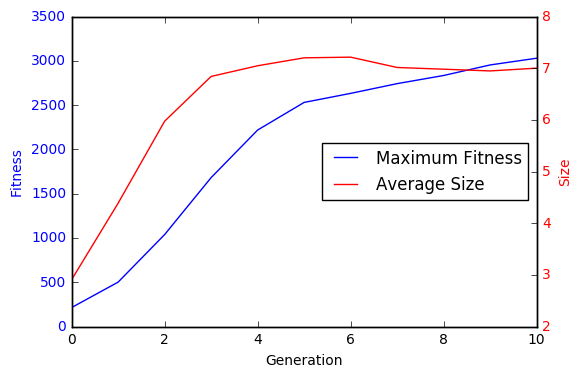

In [11]:
gen = log.select("gen")
fit_mins = log.chapters["fitness"].select("max")
size_avgs = log.chapters["size"].select("avg")

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, fit_mins, "b-", label="Maximum Fitness")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")

ax2 = ax1.twinx()
line2 = ax2.plot(gen, size_avgs, "r-", label="Average Size")
ax2.set_ylabel("Size", color="r")
for tl in ax2.get_yticklabels():
    tl.set_color("r")

lns = line1 + line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center right")

plt.show()

In [12]:
expr = hof.items[0]
nodes, edges, labels = gp.graph(expr)

function = gp.compile(expr, pset)

In [13]:
print function.get_value(), evaluate(expr)

[0-9,.!?A-Z]* (4, 15)


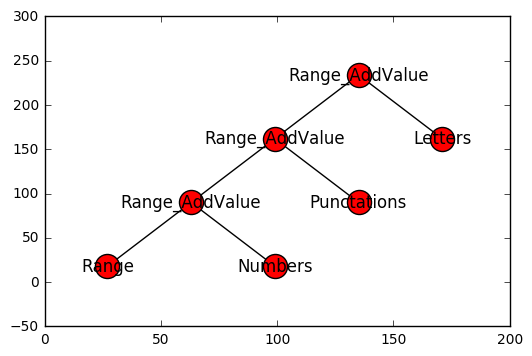

In [14]:
from networkx.drawing.nx_agraph import graphviz_layout

import matplotlib.pyplot as plt
import networkx as nx

g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
pos = graphviz_layout(g, prog="dot")

nx.draw_networkx_nodes(g, pos)
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels)
plt.show()